# Gradient Boosting

Another notebook touching on boosting, specifically gradient boosting.

## What we will accomplish

In this notebook we will:
- Learn the concept behind gradient boosting:
    - See why it is called gradient boosting and
    - Demonstrate the method with nice plots and
- Implement the algorithm in `sklearn`:
    - Define early stopping.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
set_style("whitegrid")

## Motivation

In AdaBoost we iteratively summed scaled weak classifiers to minimize the exponential loss on our training data.  At each stage we build a new classifier which pays more attention to the mistakes of the existing model.

We can apply the same idea to regression modeling with MSE as our loss function:  we can iteratively sum "simple" regressors to minimize the square loss on our training data.  At each stage we will build a new regressor on the *residuals* of the existing model.

Let's be more explicit now. Recall that in regression we try to model a quantitative variable, $y$, using $p$ features contained in a matrix, $X$. Gradient boosting for this problem then works like so:

<i>Step 1</i>
- Train a weak learner regression algorithm (say a decision stump regressor) to predict $y$, this is weak learner $1$.
- Calculate the residuals, $r_1 = y - h_1(X)$, where $h_1(X) = \hat{y}$ is the prediction of weak learner $1$.

<i>Step $j$</i>
- Train a weak learner to predict the residuals at step $j-1$, $r_{j-1}$,
    - Set $h_j(X) = \hat{r}_{j-1}$ denote the $j^\text{th}$ weak learner's estimate of the residuals.
- Calculate the residuals for this weak learner, $r_{j} = r_{j-1} - h_j(X)$.
- Stop when $j+1 = J$, a predetermined stopping point.


The prediction for $y$ at step $j$ is then found by:
$$
h(X) = h_1(X) + h_2(X) + \dots + h_j(X)
$$

Let's visualize this.

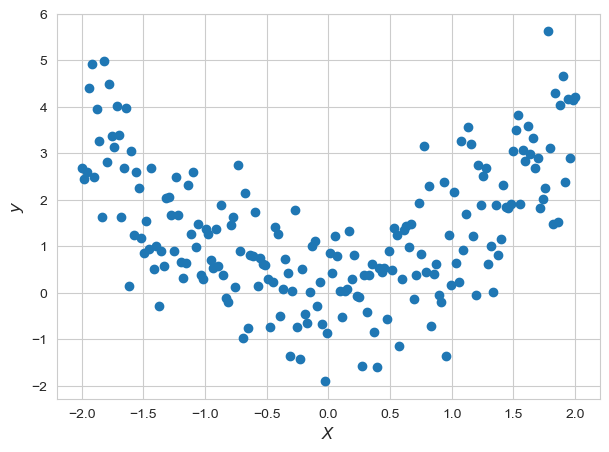

In [2]:
## Generate some data
np.random.seed(220)
X = np.linspace(-2,2,200)

y = X**2 + np.random.randn(200)

## Visualize the training data
plt.figure(figsize=(7,5))
plt.scatter(X,y)
plt.xlabel("$X$", fontsize=12)
plt.ylabel("$y$", fontsize=12)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import numpy as np

n_learners = 4
fig, ax = plt.subplots(n_learners, 2, figsize=(10, 18), sharey=True)

residual = y.copy()
predictions = np.zeros_like(y)
models = []
hs = []

for i in range(n_learners):
    tree = DecisionTreeRegressor(max_depth=1)
    tree.fit(X.reshape(-1, 1), residual)
    h = tree.predict(X.reshape(-1, 1))
    models.append(tree)
    hs.append(h)
    
    # Update predictions and residuals
    predictions += h
    residual = residual - h

    # Plot weak learner on residuals or original y
    if i == 0:
        ax[i, 0].scatter(X, y, c='lightblue', alpha=.8, label='Training Data')
        ax[i, 0].set_ylabel("$y$", fontsize=12)
    else:
        ax[i, 0].scatter(X, y - sum(hs[:i]), c='lightblue', alpha=.8, label='Residuals')
        ax[i, 0].set_ylabel(f"$r_{i}$", fontsize=12)

    ax[i, 0].plot(X, h, 'k', label=f"$h_{i+1}(X)$")
    ax[i, 0].legend(fontsize=10, loc=2)
    ax[i, 0].set_xlabel("$X$", fontsize=12)

    # Plot cumulative prediction
    ax[i, 1].scatter(X, y, c='lightblue', alpha=.8, label='Training Data')
    h_expr = " + ".join([f"h_{j+1}(X)" for j in range(i+1)])  # <-- fix here
    ax[i, 1].plot(X, predictions, 'k', label=f"$h(X)={h_expr}$")  # <-- and here
    ax[i, 1].legend(fontsize=10, loc=2)
    ax[i, 1].set_xlabel("$X$", fontsize=12)
    ax[i, 1].set_ylabel("$y$", fontsize=12)

# Add titles to top row
ax[0, 0].set_title("$h_i$ and its\ntraining data", fontsize=14)
ax[0, 1].set_title("$h$ and the\noriginal training data", fontsize=14)

plt.tight_layout()

### Why "gradient" boosting?

Let's discuss why this is known as "gradient" boosting.  We are (approximately) doing gradient descent in a function space!

Let $(x_i, y_i)$ for $i = 1,2,3,..., N$ be our training data.  Say that our current model $f$ has values $f(x_i) = \hat{y}_i$.  Thinking of each output $\hat{y}_i$ as its own parameter, the gradient of the squared error $\sum_1^N (y_i - \hat{y}_i)^2$ is $-2(y_i - \hat{y}_i)$.  So the residuals can be thought of as "pointing in the direction of steepest descent" for the squared error loss function.  When we find a new weak regressor to approximate this we are getting as "close to gradient descent as we can" given our restricted space of weak regressors.

This idea can be generalized to other loss functions!

Let 

$$L(f) = \sum_1^N L(y_i, f(x_i))$$

where $L(\cdot, \cdot)$ is any loss function.  We define an inner product with respect to our training data as $\langle f, g \rangle = \sum_1^N f(x_i)g(x_i)$

Then considering each $f(x_i) = \hat{y}_i$ as an indepedent parameter we have that the gradient of $\nabla L \big|_f = \begin{bmatrix} \partial_i L(f) \end{bmatrix}$ where  $\partial_i L(f) =  \frac{\partial}{\partial u} L(y_i, u)\big|_{u = f(x_i)}$. 

In this context these gradients are sometimes called "pseudo-residuals" in analogy with the squared error loss case.  

The general "Gradient Boosting" algorithm then works like this:

1. Choose a learning rate $\alpha$.
2. Initialize $f_0$ to be the weak learner which minimizes $L(f_0)$.
3. In each training round $j \geq 1$:
* Compute the gradient $\nabla L\big|_{f_j} = \begin{bmatrix} \partial_i L(f) \end{bmatrix}$
* Find $g_j$ which minimizes $\langle \nabla L\big|_{f_j}, g_j \rangle = \sum_1^n \partial_i L(f) g_j(x_i)$
* Set $f_{j+1} = f_j + \alpha g_j$

Note that AdaBoost is a special case of this general construction, using decision trees as our weak learner and the exponential loss function.  AdaBoost is a bit special in that the optimal value of $\alpha$ can also be computed at each stage.

## Gradient boosting in `sklearn`

While the idea of gradient boosting is quite general, in practice it is used most frequently with shallow trees as our weak learners.

`sklearn` implements gradient boosted trees for both classification and regression in the modules [`GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and [`GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) respectively.

We have the following available loss functions:

* For `GradientBoostingClassifier`:
    * `exponential` same as AdaBoost.
    * `log_loss` uses cross-entropy loss instead of exponential loss. It penalizes misclassifications less harshly than the exponential loss function, which makes it more robust to noisy or mislabeled data.
* For `GradientBoostingRegressor`:
    * `squared_error` was our motivating example.
    * `absolute_error` while not differentiable everywhere we can still attempt gradient descent.  Is more robust to outliers.
    * `huber` a compromise between squared error and absolute error.  It is a piecewise defined function which stitches together a quadratic and absolute value to be differentiable through the transition.
    * `quantile` uses [quantile loss](https://stats.stackexchange.com/a/252043/97124) with `alpha` to specify the quantile.

`max_depth` essentially controls the number of "interactions" allowed between different features.  According to Elements of Statistical Learning, the `max_depth` hyperparameter rarely needs to go above $8$.



In [5]:
## import GradientBoosting here
from sklearn.ensemble import GradientBoostingRegressor

Two ways control overfitting with a gradient boosting model is to change the number of trees we train and to change the `learning_rate`. We first demonstrate how the `learning_rate` impacts the model, then touch on the `n_estimators`.

#### `learning_rate`

The learning rate of the gradient boosting algorithm determines how much weight each weak learner recieves in the final prediction. `sklearn`'s default value is `0.1`. Let's demonstrate the difference between two `learning_rate`s now.

In [6]:
## make the first booster, rate of .1
## n_estimators = 10
## with a max_depth of 1
small_rate = GradientBoostingRegressor(n_estimators=10,
                                          max_depth=1,
                                          learning_rate=.1)

## make the second, rate of 1
large_rate = GradientBoostingRegressor(n_estimators=10,
                                          max_depth=1,
                                          learning_rate=1)


## fit both
small_rate.fit(X.reshape(-1,1), y)
large_rate.fit(X.reshape(-1,1), y)

GradientBoostingRegressor(learning_rate=1, max_depth=1, n_estimators=10)

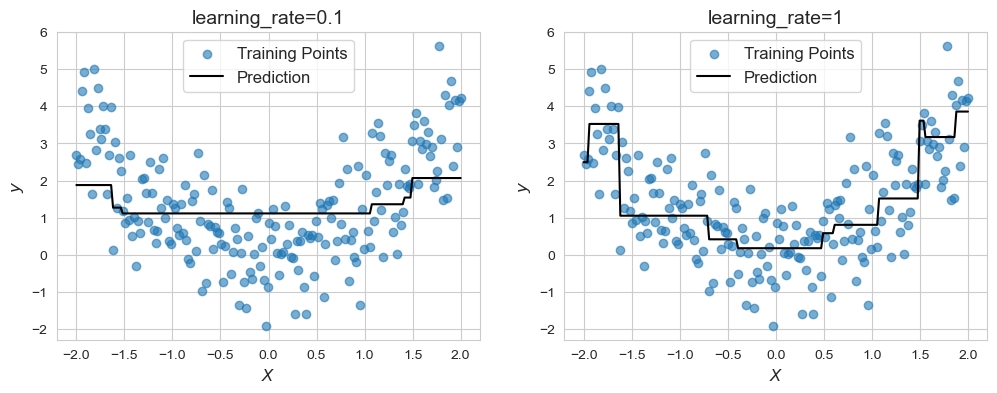

In [7]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].scatter(X, y, alpha=.6, label='Training Points')
ax[0].plot(X, small_rate.predict(X.reshape(-1,1)), 'k',label="Prediction")
ax[0].set_title("learning_rate=0.1", fontsize=14)
ax[0].legend(fontsize=12)
ax[0].set_xlabel("$X$", fontsize=12)
ax[0].set_ylabel("$y$", fontsize=12)

ax[1].scatter(X, y, alpha=.6, label='Training Points')
ax[1].plot(X, large_rate.predict(X.reshape(-1,1)), 'k',label="Prediction")
ax[1].set_title("learning_rate=1", fontsize=14)
ax[1].legend(fontsize=12)
ax[1].set_xlabel("$X$", fontsize=12)
ax[1].set_ylabel("$y$", fontsize=12)

plt.show()

It is typically preferred to use a small learning rate and train more trees than to use a large learning rate.

#### `n_estimators` and early stopping

A second way to control over/underfitting a gradient booster is by controlling the number of weak learners you train. 

One way to find this that may be preferable to cross-validation is to use a validation set. You track the error on the validation set as you train each additional weak learner. Then you pick the number of weak learners that had the lowest validation set error.

Let's demonstrate the method `staged_predict` which retuns an iterator over the predictions made by the booster at each level (with one tree, with two trees and so on).

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [10]:
## import mse
from sklearn.metrics import mean_squared_error

In [11]:
## Make a new booster
n_trees = 200
gb = GradientBoostingRegressor(max_depth=1,
                               n_estimators=n_trees)

## fit the booster
gb.fit(X_train.reshape(-1,1), y_train)

GradientBoostingRegressor(max_depth=1, n_estimators=200)

In [12]:
for thing in gb.staged_predict(X_val.reshape(-1,1)):
    print(thing)

[1.27958044 1.27958044 1.27958044 1.27958044 1.27958044 1.27958044
 1.27958044 1.27958044 1.27958044 1.27958044 1.27958044 1.27958044
 1.27958044 1.27958044 1.27958044 1.49672026 1.27958044 1.27958044
 1.27958044 1.27958044]
[1.25045026 1.25045026 1.25045026 1.25045026 1.25045026 1.4377157
 1.25045026 1.25045026 1.25045026 1.25045026 1.25045026 1.25045026
 1.25045026 1.25045026 1.25045026 1.65485553 1.25045026 1.25045026
 1.25045026 1.25045026]
[1.23069976 1.23069976 1.23069976 1.48463474 1.23069976 1.41796521
 1.48463474 1.48463474 1.23069976 1.23069976 1.23069976 1.23069976
 1.23069976 1.23069976 1.23069976 1.63510503 1.23069976 1.23069976
 1.48463474 1.48463474]
[1.2057893  1.2057893  1.2057893  1.45972428 1.2057893  1.39305474
 1.45972428 1.45972428 1.2057893  1.2057893  1.2057893  1.2057893
 1.2057893  1.2057893  1.2057893  1.78954992 1.2057893  1.2057893
 1.45972428 1.45972428]
[1.18780376 1.18780376 1.18780376 1.67298136 1.18780376 1.3750692
 1.67298136 1.67298136 1.18780376 1.1

In [13]:
## use a list comprehension and staged_predict to get validation errors
mses = [mean_squared_error(y_val, predicted) for predicted in gb.staged_predict(X_val.reshape(-1,1))]

In [14]:
mses

[1.464522136930788,
 1.4533425366358752,
 1.322216713490605,
 1.3187873837713737,
 1.2214366861957178,
 1.2146415077326524,
 1.1526719637220757,
 1.1367854288589132,
 1.0832255475310144,
 1.0707498956116117,
 1.040055588480712,
 1.038450075246292,
 1.0139539876240071,
 1.0038819000680117,
 0.9944564459402729,
 0.9935326527091105,
 0.9931144231377182,
 0.9850139542677064,
 0.9839973134103659,
 0.9775816449686114,
 0.9861878577864763,
 0.9861572891244288,
 0.9963229247995244,
 0.9915175064080565,
 1.000520830335858,
 1.002843800344451,
 1.0160358486387886,
 0.9973592904867014,
 1.006652723148465,
 1.0032424634318624,
 1.017662311972032,
 1.0193754562537303,
 1.0311654059706419,
 1.01553954345222,
 1.0272973571654753,
 1.0274407713365385,
 1.046013096150713,
 1.0321805383940428,
 1.0445505098999759,
 1.0454224262498528,
 1.0627790468393654,
 1.0499591554704484,
 1.0625665374921076,
 1.0634860678750377,
 1.0757491564173283,
 1.0562520816668806,
 1.0682489707104046,
 1.0569439573185155,
 1.

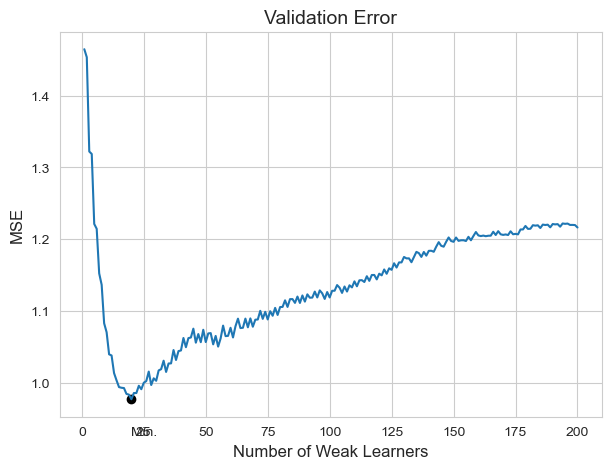

In [15]:
plt.figure(figsize=(7,5))

plt.plot(range(1,n_trees+1), mses)
plt.scatter([range(1,n_trees+1)[np.argmin(mses)]], [np.min(mses)], c='k')
plt.text(range(1,n_trees+1)[np.argmin(mses)], np.min(mses)-.05, "Min.", fontsize=10)

plt.title("Validation Error", fontsize=14)
plt.xlabel("Number of Weak Learners", fontsize=12)
plt.ylabel("MSE", fontsize=12)

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.show()

In [16]:
range(1,n_trees+1)[np.argmin(mses)]

20

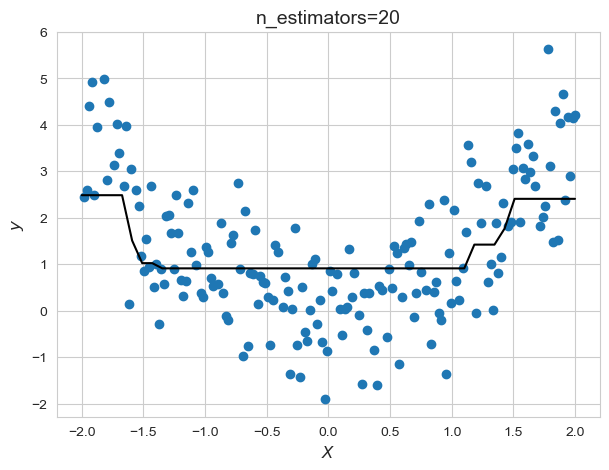

In [17]:
best_num = range(1,n_trees+1)[np.argmin(mses)]
gb = GradientBoostingRegressor(max_depth=1, n_estimators=best_num)
gb.fit(X_train.reshape(-1,1),y_train)

plt.figure(figsize=(7,5))

plt.scatter(X_train,y_train,label='Training Points')
plt.plot(np.linspace(-2,2), gb.predict(np.linspace(-2,2).reshape(-1,1)), 'k',label="Prediction")
plt.title("n_estimators="+str(best_num), fontsize=14)
plt.xlabel("$X$", fontsize=12)
plt.ylabel("$y$", fontsize=12)

plt.show()

#### Early stopping

We can also implement what is known as <i>early stopping</i>, where we stop training additional layers when it appears that we have reached a minimum. This saves time compared to training many trees and then looking retrospectively to find the best one.  

We first implement early stopping "by hand". We will then see how to do it using built in methods. For our custom implementation we use the `warm_start` argument, which forces `sklearn` to keep older layers when the fit method is called. Let's see what we mean now.

In [18]:
## make the model object
gb = GradientBoostingRegressor(max_depth=1, warm_start=True)

## an initial value
min_validation_error = float("inf")

val_errors = []

## to keep track of if our error went up
times_error_went_up_in_a_row = 0

for n_estimators in range(1,500):
    print("Training weak learner", n_estimators)
    # set the number of estimators
    gb.n_estimators = n_estimators
    
    # fit/refit the model
    gb.fit(X_train.reshape(-1,1), y_train)
    
    # record the validation error
    val_errors.append(mean_squared_error(y_val, gb.predict(X_val.reshape(-1,1))))
    
    ## check if the error went up or down
    # if it went down
    if val_errors[-1] < min_validation_error:
        # record the new minimum val error
        min_validation_error = val_errors[-1]
        
        # reset our up counter
        times_error_went_up_in_a_row = 0
    # if it went up
    else:
        # add to the counter
        times_error_went_up_in_a_row = times_error_went_up_in_a_row + 1
        # if this is the 5th time in a row it has gone up
        if times_error_went_up_in_a_row == 10:
            # stop early
            break

Training weak learner 1
Training weak learner 2
Training weak learner 3
Training weak learner 4
Training weak learner 5
Training weak learner 6
Training weak learner 7
Training weak learner 8
Training weak learner 9
Training weak learner 10
Training weak learner 11
Training weak learner 12
Training weak learner 13
Training weak learner 14
Training weak learner 15
Training weak learner 16
Training weak learner 17
Training weak learner 18
Training weak learner 19
Training weak learner 20
Training weak learner 21
Training weak learner 22
Training weak learner 23
Training weak learner 24
Training weak learner 25
Training weak learner 26
Training weak learner 27
Training weak learner 28
Training weak learner 29
Training weak learner 30


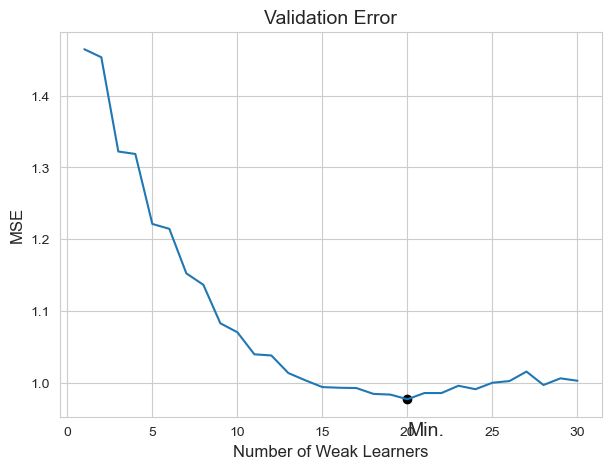

In [19]:
plt.figure(figsize=(7,5))

plt.plot(range(1,n_estimators+1), val_errors)
plt.scatter([range(1,n_estimators+1)[np.argmin(val_errors)]], [np.min(val_errors)], c='k')
plt.text(range(1,n_estimators+1)[np.argmin(val_errors)], np.min(val_errors)-.05, "Min.", fontsize=14)

plt.title("Validation Error", fontsize=14)
plt.xlabel("Number of Weak Learners", fontsize=12)
plt.ylabel("MSE", fontsize=12)

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.show()

Now let's see how to use built-in functionality for early stopping.

In [20]:
gb = GradientBoostingRegressor(max_depth=1, validation_fraction = 0.1, n_iter_no_change = 10, tol = 10**(-4))

gb.fit(X.reshape(-1,1), y)


GradientBoostingRegressor(max_depth=1, n_iter_no_change=10)

In [21]:
gb.n_estimators_

100

Note that this is different from the early stopping number we obtained above because of the difference in train/validation split.  Running the last two cells multiple times gives a feel for the variability in the early stopping number of estimators.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)